In [1]:
import os
import glob
import math

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imsave, imread

In [2]:
import mxnet as mx
import mxnet.ndarray as nd

from mxnet import gluon
from mxnet.image import color_normalize

In [19]:
DATA_DIR = '../data/tulips/bloom/'
IMG_DIR = os.path.join(DATA_DIR, '16/')
CHECKPOINTS_DIR = 'checkpoints'

In [4]:
ctx = mx.gpu(0)

Load the pretrained network

In [5]:
net = gluon.model_zoo.vision.resnet101_v2(classes=2, ctx=ctx)

Load weights from saved checkpoint

In [6]:
net.load_params(os.path.join(CHECKPOINTS_DIR, 'resnet100-bin', '43-0.params'), ctx)

In [7]:
labels = {0:'clear', 1:'cloudy'}

In [8]:
mean = mx.nd.array([0.485, 0.456, 0.406], ctx=ctx).reshape((3,1,1))
std =  mx.nd.array([0.229, 0.224, 0.225], ctx=ctx).reshape((3,1,1))

In [9]:
# Would center cropping make more sense?
augs = [ 
     mx.image.CenterCropAug((224, 224))
]

In [10]:
def preprocess(data, augs):
    data = mx.nd.array(data).astype('float32').as_in_context(ctx)
    for aug in augs:
        data = aug(data)
    data = mx.nd.transpose(data, (2,0,1))
    data = color_normalize(data/255, mean, std)
    return data

In [11]:
def read_img(filename):
    img = mx.image.imread(filename)
    return preprocess(img, augs)

In [12]:
def load_batch(filenames):
    batch = mx.nd.empty((len(filenames),3,224,224))
    for idx,fn in enumerate(filenames):
        batch[idx] = read_img(fn)
    
    return batch

In [13]:
def filter_folder(root, batch_size, net, ext='.png'):
    print("Scanning dir {}".format(root))
    files = glob.glob(root + '*wms*' + ext)
    print("Found {} images".format(len(files)))
    cloudy = []
    nbatches = math.ceil(len(files)/batch_size)
    
    for n in range(nbatches):
        files_batch = files[n*batch_size:(n+1)*batch_size]
        batch = load_batch(files_batch)
        batch = batch.as_in_context(ctx)
        output = net(batch)
        preds = mx.nd.argmax(output, axis=1)
        idxs = np.nonzero(preds.asnumpy())[0]      
        cloudy.extend([files_batch[i] for i in idxs])
        
    # Do something with the cloudy images (delete/move to new directory)
    print('Found {} cloudy images'.format(len(cloudy)))
    return cloudy

In [20]:
cloudy = filter_folder(IMG_DIR, 64, net)

Scanning dir ../data/tulips/bloom/16/
Found 5621 images
Found 836 cloudy images


Lets visualize some of the filtered images

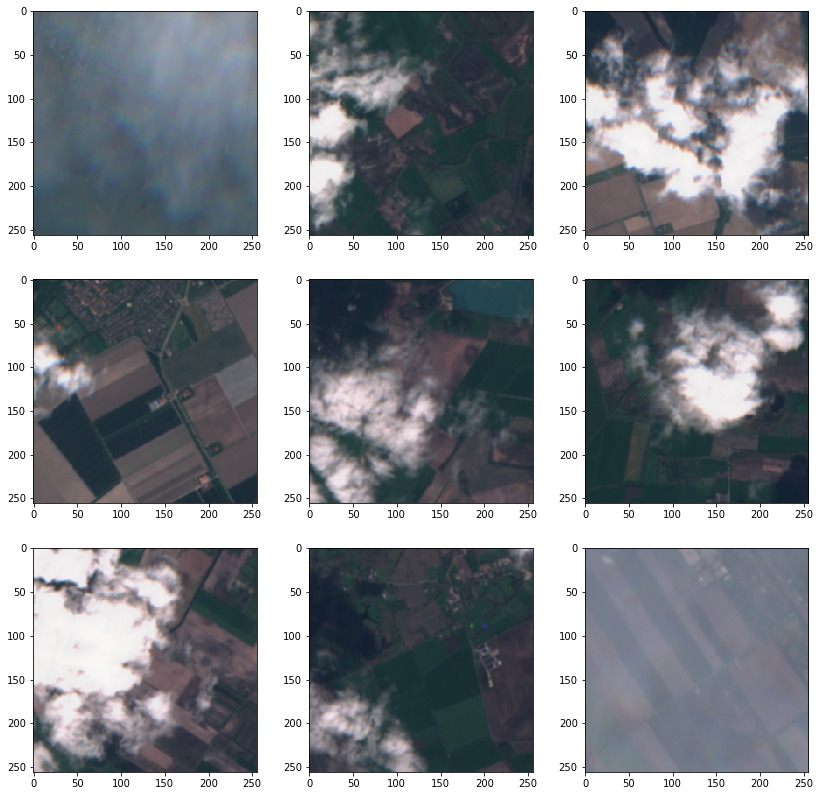

In [21]:
import random
sample = random.sample(cloudy, 9)

plt.subplots(figsize=(14, 14))
for idx, img in enumerate(sample):
    plt.subplot(3, 3, idx+1)
    plt.imshow(imread(img))